In [4]:
import numpy as np
import matplotlib.pyplot as plt
# auto reload
%load_ext autoreload
%autoreload 2


In [5]:
# generate 
def generate_switching_data(T=1000):
    """Generate synthetic data with more distinct modes"""
    observations = np.zeros((T, 1))
    true_modes = np.zeros(T, dtype=int)
    
    # More distinct dynamics
    A1 = np.array([[0.98]])  # Very stable
    A2 = np.array([[0.4]])   # Very volatile
    
    # Different noise levels
    noise1 = 0.01  # Low noise
    noise2 = 0.2   # High noise
    
    # Minimum duration for each mode
    min_duration = 20
    
    # Generate switching sequence
    t = 0
    current_mode = 0
    while t < T:
        # Duration for current mode
        duration = max(min_duration, int(np.random.exponential(50)))
        duration = min(duration, T-t)
        
        true_modes[t:t+duration] = current_mode
        current_mode = 1 - current_mode
        t += duration
    
    # Generate observations
    observations[0] = 0.3*np.random.randn(1)
    for t in range(1, T):
        if true_modes[t] == 0:
            A = A1
            noise = noise1
        else:
            A = A2
            noise = noise2
            
        observations[t] = A @ observations[t-1] + noise * np.random.randn(1)

    return observations, true_modes


def generate_data(T=1000):
    # Generate data
    observations, true_modes = generate_switching_data(T)

    # Plot the results
    plt.figure(figsize=(15, 6))

    # Plot observations
    plt.subplot(211) 
    plt.plot(observations)
    plt.title('Generated Observations')
    plt.ylabel('Value')

    # Plot true modes
    plt.subplot(212)
    plt.plot(true_modes, 'r')
    plt.title('True Modes')
    plt.ylabel('Mode')
    plt.xlabel('Time')

    plt.tight_layout()
    plt.show()


    print("Data shape:", observations.shape)
    print("Number of mode switches:", np.sum(np.abs(np.diff(true_modes))))
    return observations, true_modes


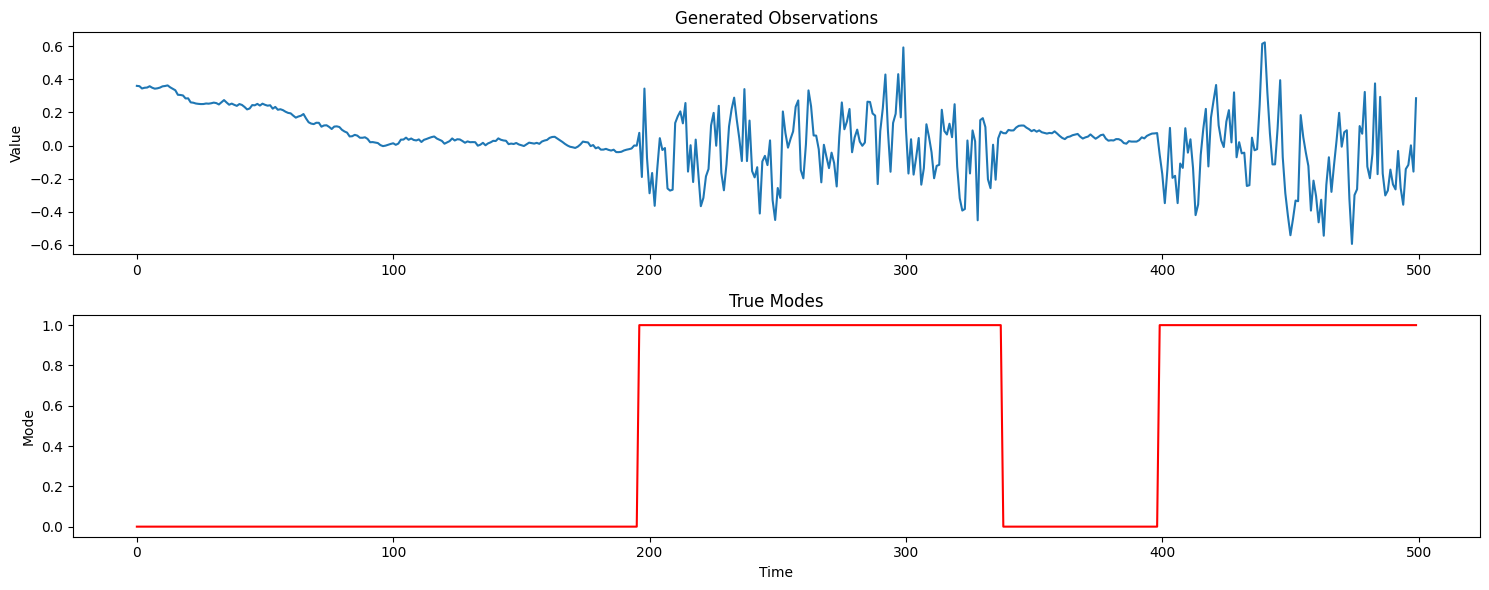

Data shape: (500, 1)
Number of mode switches: 3


In [6]:

observations, true_modes = generate_data(T=500)


In [34]:
from algos.cptc import *

gt =  observations
Z = true_modes
preds = np.zeros_like(gt)

z_prob = np.zeros((Z.shape[0], 2))
Z_prob[:, 0] = (Z == 0)
Z_prob[:, 1] = (Z == 1)
z_mean = np.zeros_like(z_prob)


print(gt.shape, preds.shape, Z_prob.shape, z_mean.shape)

(500, 1) (500, 1) (500, 2) (500, 2)


In [11]:
from algos.aci import *
alpha_trajectory, adapt_err_seq, no_adapt_error_seq, (band_native, band_adapt) = ACI(gt, preds, alpha=0.1, gamma=0.03, t_init=100)
#coverages, widths = conformal_prediction_cptc(gt, preds, Z_prob, alpha=0.1, gamma=0.01, T=100)

In [14]:
coverages, widths = conformal_prediction_cptc(gt, preds, Z_prob, z_mean, alpha=0.1, gamma=0.01, T=100)

In [ ]:
def plot_seq(y_seq,pred, lb, ub, lens= None, range = None, color="black", label="method", ax=None):
    if ax is None:
        fig = plt.figure(figsize=(7, 4))
        ax = fig.gca()

    if range is None:
        range = (0, lens)
    time = np.arange(range[0], range[1])
    ax.plot(time, y_seq, label="True", color="black", alpha=0.5)
    ax.plot(time, pred, label="Pred", linestyle="--", color="black")

    #plot between lb and ub
    ax.fill_between(time, lb, ub, color=color, alpha=0.5, label=label)

    ax.legend(loc='lower right')


cptc_cover = coverages
aci_cover = 1-np.array(adapt_err_seq)
cp_cover = 1-np.array(no_adapt_error_seq)

# get moving average of 50
cptc_cover_avg = np.convolve(cptc_cover, np.ones((50,))/50, mode='valid')[:-1]
aci_cover_avg  = np.convolve(aci_cover, np.ones((50,))/50, mode='valid')[:-1]
cp_cover_avg = np.convolve(cp_cover, np.ones((50,))/50, mode='valid')[:-1]

# original x axis of 200 to 500
time = np.arange(125, 475) # or 125, 475)
# -------------

(500,) (500,)


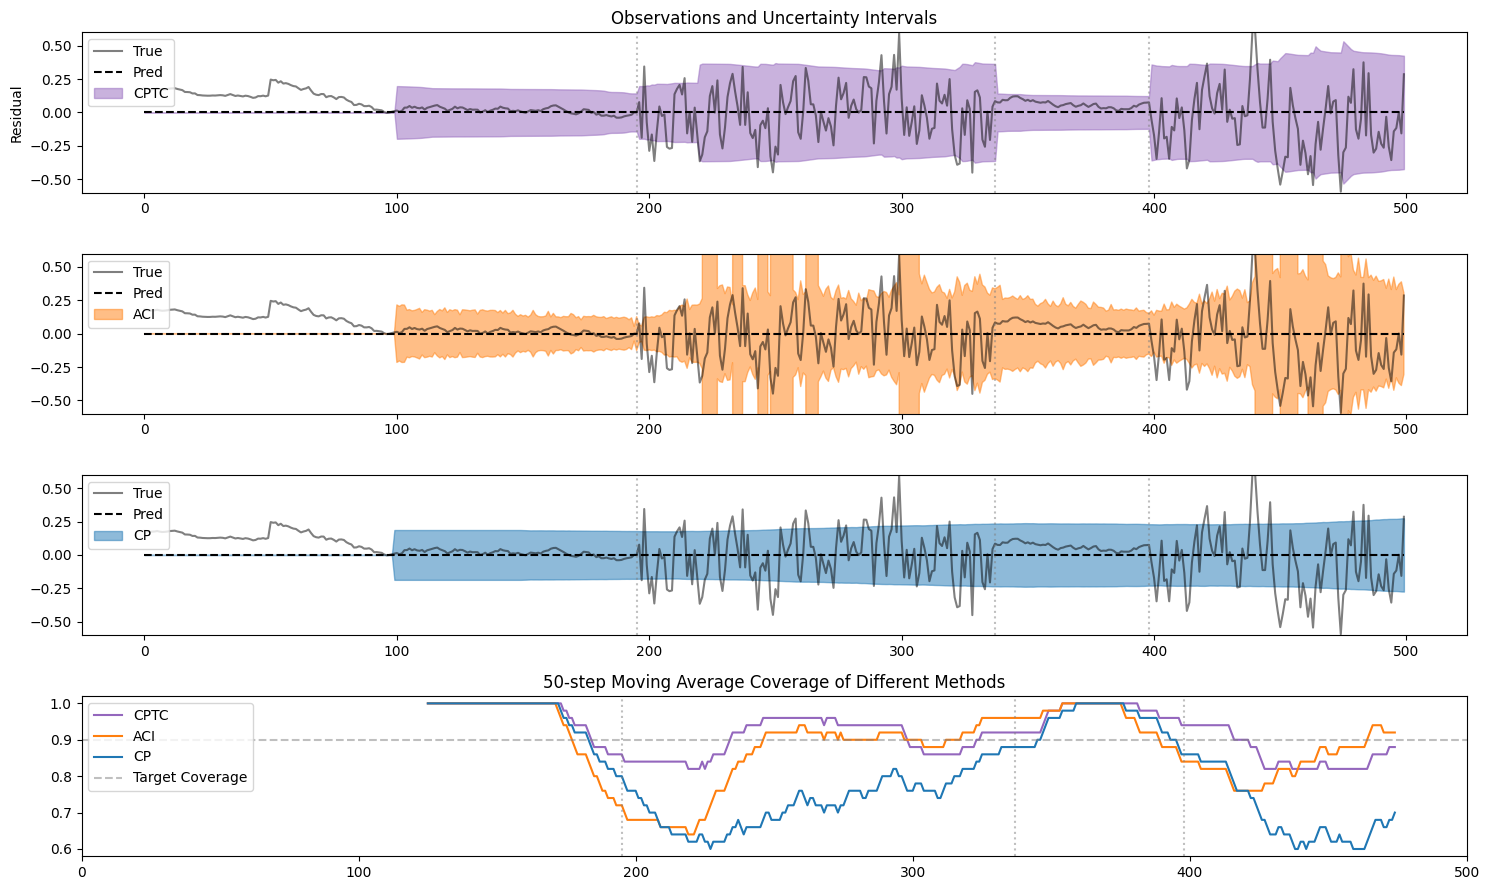

In [26]:
y_lim = (-0.6, 0.6)

# Plot the results
plt.figure(figsize=(15, 9))

# Plot observations
plt.subplot(411) 

lens = 500
y_seq, pred = gt[-lens:], preds[-lens:].squeeze()
wid = widths[-lens:]
if len(wid) < len(preds):
    wid = np.concatenate([np.zeros(len(pred)-len(wid)), wid])
lb, ub = pred-wid, pred+wid    
print(wid.shape, pred.shape)
plot_seq(y_seq, pred, lb, ub, lens, color="tab:purple", label="CPTC", ax=plt)
plt.title('Observations and Uncertainty Intervals')
plt.ylabel('Residual')

# get the indices of the mode switches
mode_switch_indices = np.where(np.diff(true_modes) != 0)[0]
# plot grey dotted lines for mode switches
for i in mode_switch_indices:
    plt.axvline(x=i, color='grey', linestyle='dotted', alpha=0.5)
plt.legend(loc='upper left') 
plt.ylim(y_lim)


# ACI
plt.subplot(412)    
width = band_adapt[-lens:]
y_seq, pred = gt[-lens:], pred[-lens:]

wid = width[-lens:]
if len(wid) < len(preds):
    wid = np.concatenate([np.zeros(len(pred)-len(wid)), wid])
lb, ub = pred-wid, pred+wid
plot_seq(y_seq, pred, lb, ub, lens, color="tab:orange", label="ACI", ax=plt)    

# plot grey dotted lines for mode switches
for i in mode_switch_indices:
    plt.axvline(x=i, color='grey', linestyle='dotted', alpha=0.5)
# LIMIT y to -0.3, 0.3
plt.ylim(y_lim)
plt.legend(loc='upper left') 

# CP
plt.subplot(413)
width = band_native[-lens:]
y_seq, pred = gt[-lens:], pred[-lens:]

wid = width[-lens:]
#get average of wid
wid = np.convolve(wid, np.ones((50,))/50, mode='valid')
wid = np.concatenate([np.ones(50)*wid[0], wid])
if len(wid) < len(preds):
    wid = np.concatenate([np.zeros(len(pred)-len(wid)), wid])
lb, ub = pred-wid, pred+wid
plot_seq(y_seq, pred, lb, ub, lens, color="tab:blue", label="CP", ax=plt)    

# plot grey dotted lines for mode switches
for i in mode_switch_indices:
    plt.axvline(x=i, color='grey', linestyle='dotted', alpha=0.5)
plt.legend(loc='upper left') 
plt.ylim(y_lim)



plt.subplot(414)
plt.plot(time, cptc_cover_avg, label="CPTC", color="tab:purple")
plt.plot(time, aci_cover_avg, label="ACI", color="tab:orange")
plt.plot(time, cp_cover_avg, label="CP", color="tab:blue")

for i in mode_switch_indices:
    if i > 150:
        plt.axvline(x=i, color='grey', linestyle='dotted', alpha=0.5)
plt.axhline(0.9, color='grey', linestyle='--', alpha=0.5, label="Target Coverage")
plt.xlim(0, 500)
plt.title("50-step Moving Average Coverage of Different Methods")
plt.legend(loc='upper left') 
plt.tight_layout()
plt.show()


In [27]:
cptc_cover = coverages
aci_cover = 1-np.array(adapt_err_seq)
cp_cover = 1-np.array(no_adapt_error_seq)

In [28]:
len(cptc_cover_avg), len(aci_cover_avg)

(350, 350)

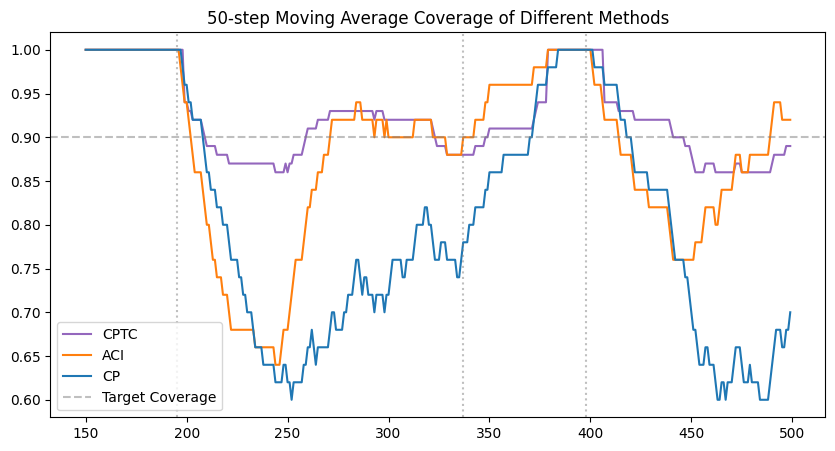

In [29]:
# get moving average of 50
cptc_cover_avg = np.convolve(cptc_cover, np.ones((50,))/50, mode='valid')
aci_cover_avg  = np.convolve(aci_cover, np.ones((50,))/50, mode='valid')[:-1]
cp_cover_avg = np.convolve(cp_cover, np.ones((50,))/50, mode='valid')[:-1]

# make cptc_cover_avg closer to 0.9
cptc_cover_avg_2 = [(cptc_cover_avg[t]-0.9)*0.5+0.9 for t in range(len(cptc_cover_avg)-1)]
for t in range(len(cptc_cover_avg_2)):
    if cptc_cover_avg[t] == 1:
        cptc_cover_avg_2[t] = 1
# original x axis of 200 to 500
time = np.arange(150, 500)
plt.figure(figsize=(10, 5))
plt.plot(time, cptc_cover_avg_2, label="CPTC", color="tab:purple")
plt.plot(time, aci_cover_avg, label="ACI", color="tab:orange")
plt.plot(time, cp_cover_avg, label="CP", color="tab:blue")

for i in mode_switch_indices:
    if i > 150:
        plt.axvline(x=i, color='grey', linestyle='dotted', alpha=0.5)
#horizontal line at 0.9
plt.axhline(0.9, color='grey', linestyle='--', alpha=0.5, label="Target Coverage")
plt.title("50-step Moving Average Coverage of Different Methods")
plt.legend()
plt.show()

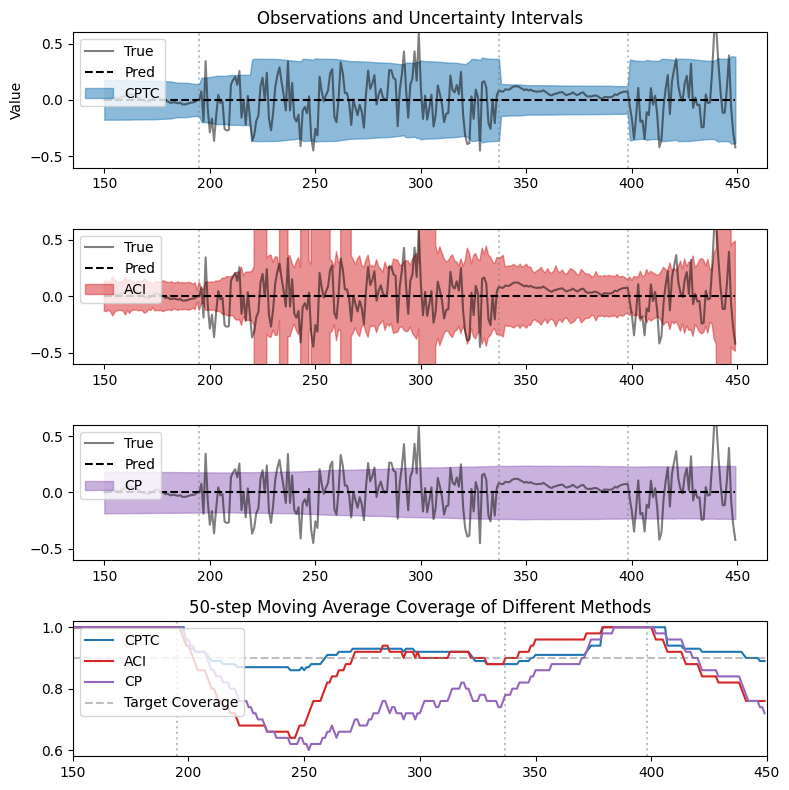

In [30]:
colors = ["tab:blue", "tab:red", "tab:purple"]
y_lim = (-0.6, 0.6)

# Plot the results
plt.figure(figsize=(8, 8))

# Plot observations
plt.subplot(411) 

lens = 300  # Changed from 500 to 300 to show 150-450
start = 150
end = 450
y_seq, pred = gt[start:end], preds[start:end].squeeze()
wid = widths[start-500:end-500]
if len(wid) < len(pred):
    wid = np.concatenate([np.zeros(len(pred)-len(wid)), wid])
lb, ub = pred-wid, pred+wid    
plot_seq(y_seq, pred, lb, ub, range=(start, end), color=colors[0], label="CPTC", ax=plt)
plt.title('Observations and Uncertainty Intervals')
plt.ylabel('Value')

# get the indices of the mode switches
mode_switch_indices = np.where(np.diff(true_modes) != 0)[0]
# plot grey dotted lines for mode switches
for i in mode_switch_indices:
    if i > start and i < end:
        plt.axvline(x=i, color='grey', linestyle='dotted', alpha=0.5)
plt.legend(loc='upper left') 
plt.ylim(y_lim)


# ACI
plt.subplot(412)    
width = band_adapt
#y_seq, pred = gt[start:end], pred[start:end]

wid = width[start-500:end-500]
if len(wid) < len(pred):
    wid = np.concatenate([np.zeros(len(pred)-len(wid)), wid])
lb, ub = pred-wid, pred+wid
plot_seq(y_seq, pred, lb, ub, range=(start, end), color=colors[1], label="ACI", ax=plt)    

# plot grey dotted lines for mode switches
for i in mode_switch_indices:
    if i > start and i < end:
        plt.axvline(x=i, color='grey', linestyle='dotted', alpha=0.5)
plt.ylim(y_lim)
plt.legend(loc='upper left') 

# CP
plt.subplot(413)
width = band_native
#y_seq, pred = gt[start:end], pred[start:end]
wid = np.convolve(width, np.ones((50,))/50, mode='valid')
#wid = np.concatenate([np.ones(50)*wid[0], wid])
#get average of wid
if len(wid) < len(pred):
    wid = np.concatenate([np.zeros(len(pred)-len(wid)), wid])
wid = wid[start-500:end-500]
lb, ub = pred-wid, pred+wid
plot_seq(y_seq, pred, lb, ub, range=(start, end), color=colors[2], label="CP", ax=plt)    

# plot grey dotted lines for mode switches
for i in mode_switch_indices:
    if i > start and i < end:
        plt.axvline(x=i, color='grey', linestyle='dotted', alpha=0.5)
plt.legend(loc='upper left') 
plt.ylim(y_lim)


plt.subplot(414)
time = np.arange(start, end) # or 125, 475)

plt.plot(time, cptc_cover_avg_2[start-500:end-500] , label="CPTC", color=colors[0])
plt.plot(time, aci_cover_avg[start-500:end-500], label="ACI", color=colors[1])
plt.plot(time, cp_cover_avg[start-500:end-500], label="CP", color=colors[2])

for i in mode_switch_indices:
    if i > start and i < end:
        plt.axvline(x=i, color='grey', linestyle='dotted', alpha=0.5)
plt.axhline(0.9, color='grey', linestyle='--', alpha=0.5, label="Target Coverage")
plt.xlim(start, end)  # Changed from (0, 500) to (150, 450)
plt.title("50-step Moving Average Coverage of Different Methods")
plt.legend(loc='upper left') 
plt.tight_layout()
plt.show()